In [53]:
# Some dependencies, you may need to install them, if you do then uncomment the following lines
# using Pkg
# Pkg.add("Plots")
# Pkg.add("Symbolics")
# Pkg.add("DataFrames")
using Symbolics
using DataFrames
using Plots

## Error metrics

In [54]:
function error_metric(xaprox::Float64, xtarget::Float64, is_absolute::Bool)
    
    """
        This function calculates the error between the aproximation and the real value
        

        Parameters
        ----------
        xaprox: Float64, The aproximation of the of the function.
        xtarget: Float64, The real value we want.
        is_absolute: Bool, If true then the error is absolute, if false then the error is relative.

        Returns
        -------
        Float64, The error between the aproximation and the real value of the root of the function.
    """
    
    if is_absolute
        return abs(xtarget - xaprox) 
    else
        return abs(xtarget - xaprox)/xtarget
    end
    
end

error_metric (generic function with 1 method)

## Fake position and bisection

In [55]:

function loop_and_search(f::Function, update_c::Function, a::Float64, b::Float64, tol::Float64, max_iter::Int64, target_value::Float64, is_absolute_error::Bool)
    
    
    """
    This function finds the root of a function f using the way of updating the midpoint c, 
    given by update_c and the interval [a,b]. The tolerance is given by tol. 
    The maximum number of iterations is given by max_iter.

    Parameters:
    ------------
        f: function which we want to find the root for
        update_c: function which updates the value of c (the midpoint, which should be very close to the root)
        a: left endpoint of the interval
        b: right endpoint of the interval
        tol: tolerance for the root
        max_iter: maximum number of iterations

        
    Returns:
    ------------
        c: midpoint of the interval, which should be very close to the root of f
        iters: number of iterations needed to find the root
    """

    c = update_c(f, a, b)
    value = f(c)
    iters = 1

    while (error_metric(value, target_value, is_absolute_error) > tol) && (iters < max_iter)

        if (value*f(a) < 0)
            b = c 
        elseif (value*f(b) < 0)
            a = c
        end

        c = update_c(f, a, b)
        value = f(c)
        iters += 1
    end

    return c, iters
end

loop_and_search (generic function with 1 method)

In [56]:

function update_c_bisection(f::Function, a::Float64, b::Float64)
    return (a+b)/2
end

update_c_bisection (generic function with 1 method)

In [57]:

function update_c_fake_position(f::Function, a::Float64, b::Float64)
    return (b - (f(b)*(b-a))/(f(b) - f(a)))
end

update_c_fake_position (generic function with 1 method)

In [58]:
function bisection_method(f::Function,
                          lower_bound::Float64,
                          upper_bound::Float64,
                          tol::Float64,
                          max_iter::Integer,
                          target_value::Float64,
                          is_absolute_error::Bool)
    return loop_and_search(f, update_c_bisection, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end 

function bisection_method_wrapper(f::Function,
                                  df::Function,
                                  x0::Float64,
                                  lower_bound::Float64,
                                  upper_bound::Float64,
                                  tol::Float64,
                                  max_iter::Integer,
                                  target_value::Float64,
                                  is_absolute_error::Bool)

    """
        This function is an standard wrapper for the bisection method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function loop_and_search with the corresponding parameters.
    """

    return loop_and_search(f, update_c_bisection, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)

end

bisection_method_wrapper (generic function with 1 method)

In [59]:
function fake_position(f::Function,
                       lower_bound::Float64,
                       upper_bound::Float64,
                       tol::Float64,
                       max_iter::Integer,
                       target_value::Float64,
                       is_absolute_error::Bool)
    return loop_and_search(f, update_c_fake_position, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end

function fake_position_wrapper(f::Function,
                               df::Function,
                               x0::Float64,
                               lower_bound::Float64,
                               upper_bound::Float64,
                               tol::Float64,
                               max_iter::Integer, 
                               target_value::Float64,
                               is_absolute_error::Bool)
    """
        This function is an standard wrapper for the fake position method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function loop_and_search with the corresponding parameters.
    """

    return loop_and_search(f, update_c_fake_position, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
    
end

fake_position_wrapper (generic function with 1 method)

## Fixed point iteration

In [60]:
function check_constraints(f::Function, lower_bound::Float64, upper_bound::Float64)::Bool
   
    slope = abs( (f(upper_bound) - f(lower_bound))/(upper_bound-lower_bound) )

    if slope > 1
        return false
    else
        return true
    end
end

function check_constraints_df(df::Function, x_value::Float64)::Bool
    slope = abs(df(x_value)) 
    # slope > 1 its not a good idea
    return slope < 1
end

check_constraints_df (generic function with 1 method)

In [61]:
function fixed_point_iteration(f::Function,
                               df::Function,   
                               x0::Float64,
                               lower_bound::Float64,
                               upper_bound::Float64,
                               tol::Float64,
                               maxiter::Int64, 
                               target_value::Float64,
                               is_absolute_error::Bool)
    
    if  !check_constraints_df(df, x0)
        println("The function does not meet the requirements for the fixed point iteration method")
        return x0, maxiter
    end

    x = x0

    for i in 1:maxiter
        x = f(x)

        if (x - tol) < lower_bound || (x + tol) > upper_bound
            break

        elseif error_metric(x, target_value, is_absolute_error) < tol
            return x, i
        end
    end

    return x, maxiter
end

function fixed_point_iteration_wrapper(f::Function,
                                       df::Function,
                                       x0::Float64,
                                       lower_bound::Float64,
                                       upper_bound::Float64,
                                       tol::Float64,
                                       max_iter::Integer,
                                       target_value::Float64,
                                       is_absolute_error::Bool)

    """
        This function is an standard wrapper for the fixed point iteration method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function fixed_point_iteration with the corresponding parameters.
    """

    return fixed_point_iteration(f, df, x0, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end 


fixed_point_iteration_wrapper (generic function with 1 method)

## Newton Rapson

In [62]:
function newton_rapson_method(f::Function, df::Function, x0::Float64, tol::Float64, maxiter::Integer, target_value::Float64, is_absolute_error::Bool)

    x = x0
    for i in 1:maxiter
        x = x - f(x)/df(x)
        if error_metric(f(x), target_value, is_absolute_error) < tol
            return x, i
        end
    end
    return x, maxiter
end

function newton_rapson_method_wrapper(f::Function,
                                      df::Function,
                                      x0::Float64,
                                      lower_bound::Float64,
                                      upper_bound::Float64,
                                      tol::Float64,
                                      max_iter::Integer,
                                      target_value::Float64,
                                      is_absolute_error::Bool)
    """
        This function is an standard wrapper for the newton rapson method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function newton_rapson_method with the corresponding parameters.
    """

    return newton_rapson_method(f, df, x0, tol, max_iter, target_value, is_absolute_error)
end                                       

newton_rapson_method_wrapper (generic function with 1 method)

## Secant Method

In [63]:
function check_root_in_the_middle(f::Function, x0::Float64, x1::Float64)::Bool
    if f(x0) * f(x1) > 0
        return false
    else
        return true
    end
end

function find_segment_root(f::Function, x0::Float64, x1::Float64)::Float64
    """
        Finds the root of the segments that join (x0, f(x0)) and (x1, f(x1))
    """
    return x1 - f(x1) * (x1 - x0) / (f(x1) - f(x0))
end

find_segment_root (generic function with 1 method)

In [64]:
function secant_method(f::Function,
                       x0::Float64,
                       x1::Float64,
                       tol::Float64,
                       maxiter::Int64,)
    """
        Finds the root of a function using the secant method.
        returns: the final [x0, x1] interval where the root is located.
    """
    
    if !check_root_in_the_middle(f, x0, x1)
        return x0, maxiter
    end

   for i in 1:maxiter
        x2 = find_segment_root(f, x0, x1)
        x0 = x1
        x1 = x2

        if abs(f(x1) - f(x0)) < tol
            return x1, i
        end
    end

    return x1, maxiter
end

function secant_method_wrapper(f::Function,
                               df::Function,
                               x0::Float64,
                               lower_bound::Float64,
                               upper_bound::Float64,
                               tol::Float64,
                               max_iter::Integer, 
                               target_value::Float64,
                               is_absolute_error::Bool)
    """
        This function is an standard wrapper for the secant method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        The parameters that are not used are:
            - df: the derivative of the function
            - x0: the initial guess
            - is_absolute_error: if the error is absolute or relative (because the secant method has his own way of calculating the error)
        It calls the function newton_rapson_method with the corresponding parameters.
    """

    return secant_method(f, lower_bound, upper_bound, tol, max_iter)
end                                       

secant_method_wrapper (generic function with 1 method)

---


**1. (valor 2pts) Emplear los métodos de solución de ecuaciones de una variable para dar solución a las siguientes ecuaciones:**

1. $e^x − 4 + x = 0$
2. $x − 0.2 sin(x) − 0.5 = 0$
3. $\displaystyle e^{\frac{x}{2}} − x^2 − 3x = 0$
4. $e^x cos(x) − x^2 + 3x = 0$
5. $0.5x^3 + x^2 − 2x − 5 = 0$
6. $e^x − 4x^2 − 8x = 0$

In [65]:
@variables x
f1sym = exp(x) - 4 + x
f2sym = x - 0.2*Symbolics.sin(x) - 0.5
f3sym = exp(x/2) - x^2 - 3*x
f4sym = exp(x)*Symbolics.cos(x) - x^2 + 3x
f5sym = 0.5*x^3 + x^2 - 2*x - 5
f6sym = exp(x) - 4*x^2 - 8*x

fn = [f1sym, f2sym, f3sym, f4sym, f5sym, f6sym]

6-element Vector{Num}:
         x + exp(x) - 4
        x - 0.5 - 0.2sin(x)
             exp((1//2)*x) - 3x - (x^2)
 3x + cos(x)*exp(x) - (x^2)
      x^2 + 0.5(x^3) - 5 - 2x
             exp(x) - 8x - 4(x^2)

In [66]:
derivatives = [Symbolics.derivative(f, x) for f in fn]

6-element Vector{Num}:
        1 + exp(x)
       1 - 0.2cos(x)
     (1//2)*exp((1//2)*x) - 3 - 2x
 3 + cos(x)*exp(x) - 2x - exp(x)*sin(x)
      2x + 1.5(x^2) - 2
            exp(x) - 8 - 8x

In [67]:
compiledf = [Symbolics.build_function(f, x, expression = false) for f in fn]
compileddf = [Symbolics.build_function(df, x, expression = false) for df in derivatives]

6-element Vector{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", id, Expr} where id}:
 RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xa9d56c03, 0xf763ce0d, 0x69b02d88, 0xcb0eacb9, 0xc42076d2), Expr}(quote
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
    (+)(1, (exp)(x))
end)
 RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xa1abfe37, 0xd0223307, 0x7cd529de, 0xd4371e2a, 0x330b6ea7), Expr}(quote
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#


Ahora que tenemos nuestras funciones y sus derivadas compiladas podemos felizmente tratar de mirar hacia dónde convergen, y hacernos una idea sobre los métodos. Haremos dos tests, el primero es en "igualdad" de condiciones iniciales, es decir, todas van a empezar con los mismos:

- intervalos
- puntos iniciales
- tolerancia
- máximo número de iteraciones

Con esto buscamos evaluar qué tanto nos pueden servir las funciones en un primer intento asumiendo que no podemos saber mucho sobre la función y que por lo tanto no podemos escoger unos mejores puntos iniciales, o intervalos.

In [68]:
x = 0.5 # Initial guess
lower_bound = -2.0
upper_bound = 3.0
tol = 1e-4
max_iter = 1000
target_value = 0.0

methods = [(bisection_method_wrapper, "Bisection"), (fake_position_wrapper, "Fake position"),
           (fixed_point_iteration_wrapper, "Fixed point iteration"), (newton_rapson_method_wrapper, "Newton rapson"), 
           (secant_method_wrapper, "Secant method")]

#run all the methods for all the functions
results = []
count = 1

especial_x = [ 16681618 , -0.61 , -1.5 , 1 , 0.7 , -1 ]

for i in 1:length(fn)
    for method in methods   
        if method[2] == "Fixed point iteration" 
            push!(results, method[1](compiledf[i], compileddf[i], especial_x[i], lower_bound, upper_bound, tol, 10, target_value, true))
        elseif method[2] != "Fixed point iteration"
            push!(results, method[1](compiledf[i], compileddf[i], x, lower_bound, upper_bound, tol, max_iter, target_value, true))
        end
        count += 1
    end
end

The function does not meet the requirements for the fixed point iteration method


Tenga en cuenta que si en alguna función se llegó al máximo de iteraciones (1000) puede que haya tenido grandes problemas convergiendo, y si además el x al que llegó es el $x_0$ (0.5) entonces esto se traduce en que no pasó de la primera iteración por que no cumplía condiciones. 

Para el caso de "Fixed Point Iteration" el maximo de iteraciones esta limitado a 10 y el $x_0$ cambia en cada caso debido a la naturaleza del algoritmo.

In [69]:
fn[2]

x - 0.5 - 0.2sin(x)

In [70]:
performances = DataFrame(name = [methods[2] for i in 1:length(fn) for methods in methods],
                        x = [results[i][1] for i in 1:length(results)],
                        iterations = [results[i][2] for i in 1:length(results)],
                        func = x = [fn[j] for j in sort([i%6 + 1 for i in 1:length(results)])] )

#sort by name and then by iterations
#sort!(performances, [:name, :x])
show(performances, allrows=true, allcols=true)

30×4 DataFrame
 Row │ name                   x            iterations  func                              
     │ String                 Float64      Int64       Num                               
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │ Bisection                1.07373            11              x + exp(x) - 4      …
   2 │ Fake position            1.07371            24              x + exp(x) - 4      …
   3 │ Fixed point iteration    1.66816e7          10              x + exp(x) - 4      …
   4 │ Newton rapson            1.07374             3              x + exp(x) - 4      …
   5 │ Secant method            1.07373             9              x + exp(x) - 4      …
   6 │ Bisection                0.615356           13                       x - 0.5 - 0…
   7 │ Fake position            0.615417            6                       x - 0.5 - 0…
   8 │ Fixed point iteration   -2.24695            10                       x - 0.5 - 0…
   

---

### Analisis de resultados punto 1

Fixed point iteration para la primera funcion no sirve, dado que la drivada siempre es mayor a 1, y en el resto de los casos, buscando un x0 inicial adecuado para que |df(x)| < 1, el algoritmo no converge ni se acerca a las soluciones, en los otros casos encontramos que no se acerca al punto deseado con cada iteración, por el contrario se aleja.

Por otra parte observando los demas metodos vemos que coinciden en varias funciones, en las que no coinciden pueden suceder dos cosas, el metodo no converge o la función tiene mas de una raiz.

Al analizar el comportamiento general de los metodos nos damos cuenta que el metodo mas eficiente en cuando a numero de iteraciones es Newton rapson, sin embargo derivar las funciones no siempre es tarea sencilla, por lo que el metodo de Bisección es una muy buena alternativa para estos casos puntuales.

---

**2. La velocidad de una paracaidista se define como:**
<center>

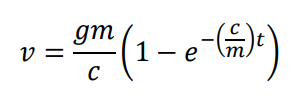

</center>

Teniendo presente que el valor aproximado de la gravedad es de 9.81𝑚/𝑠^2, emplee el método de
bisección y de falsa posición,
con un error inferior a 𝜀𝑟𝑟 ≤ 0.02 para:

* Calcular el valor de la masa que hace que el paracaidista tenga una velocidad de 𝑣 =
36𝑚/𝑠, con un coeficiente de resistencia 𝑐 = 15𝑘𝑔/𝑠 en un tiempo 𝑡 = 10𝑠.

In [71]:
g = 9.81 #m/s^2
c = 15.0 #kg/s
t = 10.0 #s
v = 36.0 #m/s

@variables m
eqn1 = (((g*m)/c) * (1 - exp(-(c/m)*t))) - v

0.654m*(1 - exp(-10.0(15.0 / m))) - 36.0

In [72]:
eqn1compiled = Symbolics.build_function(eqn1, m, expression = false)
eqn1dfcompiled = Symbolics.build_function(Symbolics.derivative(eqn1, m), m, expression = false)

RuntimeGeneratedFunction(#=in Symbolics=#, #=using Symbolics=#, :((m,)->begin
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
          (+)((*)(0.654, (+)(1, (*)(-1, (exp)((*)(-10.0, (/)(15.0, m)))))), (*)((*)((*)(-6.54, m), (/)(15.0, (^)(m, 2))), (exp)((*)(-10.0, (/)(15.0, m)))))
      end))

In [73]:
lowerbound = 30.0
upperbound = 100.0
tol = 0.02
maxiter = 100
target_value = 0.0

fake_position(eqn1compiled, lowerbound, upperbound, tol, maxiter, target_value, true)

(59.98552039786966, 4)

In [74]:
bisection_method(eqn1compiled, lowerbound, upperbound, tol, maxiter, target_value, true)

(59.94140625, 9)

In [75]:
newton_rapson_method(eqn1compiled, eqn1dfcompiled, 50.0, tol, maxiter, target_value, true)

(59.95747016243772, 2)

La masa del paracaidista es 60 kg aproximadamente.


---

* Calcular el valor del coeficiente de resistencia para que un paracaidista de 82kg tenga una velocidad de $36m/s$ después de $4s$ de caída libre.

In [76]:
g = 9.81 #m/s^2
m = 80.0 #kg
t = 4.0 #s
v = 36.0 #m/s

@variables c
eqn2 = (((g*m)/c) * (1 - exp(-(c/m)*t))) - v

(784.8000000000001(1 - exp(-0.05c))) / c - 36.0

In [77]:
eqn2compiled = Symbolics.build_function(eqn2, c, expression = false)
eqn2dfcompiled = Symbolics.build_function(Symbolics.derivative(eqn2, c), c, expression = false)

RuntimeGeneratedFunction(#=in Symbolics=#, #=using Symbolics=#, :((c,)->begin
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
          (+)((/)((*)(39.24000000000001, (exp)((*)(-0.05, c))), c), (/)((*)(-784.8000000000001, (+)(1, (*)(-1, (exp)((*)(-0.05, c))))), (^)(c, 2)))
      end))

In [78]:
lowerbound = 1.0
upperbound = 50.0
tol = 0.02
maxiter = 100
target_value = 0.0

fake_position(eqn2compiled, lowerbound, upperbound, tol, maxiter, target_value, true)

(3.5016945305172533, 3)

In [79]:
bisection_method(eqn2compiled, lowerbound, upperbound, tol, maxiter, target_value, true)

(3.48828125, 8)

In [80]:
newton_rapson_method(eqn2compiled, eqn2dfcompiled, 50.0, tol, maxiter, target_value, true)

(3.498060944031921, 6)

El coeficiente de resistencia está al rededor de 3.5


---

**3. (valor 2pts) Encuentre el máximo de la siguiente función con un error inferior al $\epsilon \leq 0.05$:**
$$f(x) = -2x^6 -1.5x^4 + 10x + 2$$

* Emplee el método de iteración de punto fijo.    
* Emplee el método de Newton – Raphson iniciando en $x_i = 1$.     
* Emplee el método de la secante a partir de $x_{i−1} = 0$ y $x_{i} = 1$.     
* Independiente de la convergencia, seleccione la técnica más adecuada para este problema. Justifique su respuesta.

In [81]:
@variables x
f7sym = -2*x^6 - 1.5*x^4 + 10*x + 2

2 + 10x - 1.5(x^4) - 2(x^6)

In [82]:
compiledf7 = Symbolics.build_function(f7sym, x, expression = false)
compileddf7 = Symbolics.build_function(Symbolics.derivative(f7sym, x), x, expression = false)
compiledddf7 = Symbolics.build_function(Symbolics.derivative(Symbolics.derivative(f7sym, x), x), x, expression = false)

RuntimeGeneratedFunction(#=in Symbolics=#, #=using Symbolics=#, :((x,)->begin
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
          (+)((*)(-18.0, (^)(x, 2)), (*)(-60, (^)(x, 4)))
      end))

Probamos iteración de punto fijo (lo intentamos mucho pero sin mucho éxito):

In [83]:
x0 = 0.1
lower_bound = 0.870
upper_bound = 0.875
tol = 0.05
max_iter = 100
target_value = 0.0

fixed_point_iteration(compileddf7, compiledddf7, x0, lower_bound, upper_bound, tol, max_iter, target_value, true)

(9.993879999999999, 100)

In [84]:
x0 = 1.0 
lower_bound = 0.1
upper_bound = 2.0
tol = 0.05
max_iter = 100
target_value = 0.0

newton_rapson_method(compileddf7, compiledddf7, x0, tol, max_iter, target_value, true)

(0.8714145262209932, 3)

In [85]:
x0 = 0.001
lower_bound = 0.0
upper_bound = 1.0
tol = 0.05
max_iter = 100
target_value = 0.9

secant_method(compileddf7, lower_bound, upper_bound, tol, max_iter)

(0.8714110507821001, 7)

El orden en que seleccionaríamos métodos sería:

1. Newton rapson, esta es nuestra herramienta más conveniente cuando conocemos la ecuación del sistema, y no es particularmente compleja para derivar, aquí tenemos una función polinómica, una delicia de derivar para cualquiera. Además es el que converge más rápido para todos los métodos cuando testeamos en el punto 1 (cuando usamos errores muy pequeños hacemos que esto prácticamente nunca converja).

2. metodo de la Secante, si bien el metodo de Newton rapson es mejor en casi todas las situaciones, el metodo de la secante tiene una gran ventaja sobre el metodo de iteración de punto fijo, puesto que no tiene una condición inicial tan problematica como este.

3. la iteración de punto fijo como última opción, esto por que es una tarea de adivinar (o brutforcear o conocer la gráfica) para seleccionar un buen intervalo que cumpla la restricción de tener una pendiente menor a 1.

---

**4. Para la siguiente tabla de datos:**


* Encuentre el polinomio interpolador de Lagrange que pasa por los puntos de la tabla
de datos.
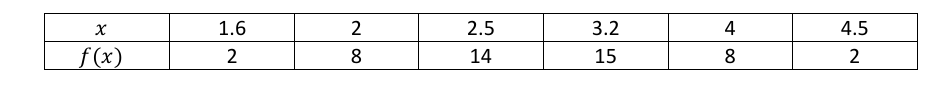

* Grafique la tabla de datos y el polinomio interpolador obtenido. 

* Calcule el valor de f(2.8)

## Lagrange

In [86]:
function lagrange_coefficients(xvalue::Float64, x::Vector, k::Int)::Float64

    """
        Calculates the lagrange coefficients for the lagrange polynomial interpolation.

        Parameters
        ----------
            xvalue: point to interpolate.
            x: list of points [x, y] to interpolate.
            k: index of the point to interpolate.
        
        Returns
        -------
            y: interpolated value.
    """

    n = length(x)
    numerator = 1
    denominator = 1

    for j = 1:n
        if j != k
            numerator = numerator * (xvalue - x[j])
            denominator = denominator * (x[k] - x[j])
        end
    end

    return numerator / denominator
end

function lagrange_polynomial(points::Vector{Vector{Float64}}, x::Float64)
    """
        Polynomial Interpolation, with lagrange polynomials.

        Parameters
        ----------
            points: list of points [x, y] to interpolate.
            x: point to interpolate.
        
        Returns
        -------
            y: interpolated value.
    """

    y = 0.0
    xpoints = [points[i][1] for i in 1:length(points)]
    ypoints = [points[i][2] for i in 1:length(points)]

    for k in 1:length(points)
        pointx = xpoints[k]
        pointy = ypoints[k]

        y += pointy * lagrange_coefficients(x, xpoints, k)
    end

    return y 
end

lagrange_polynomial (generic function with 1 method)

In [87]:
function plot_lagrange(points::Vector{Vector{Float64}}, step::Float64)
    """
        Plot the lagrange polynomial interpolation.

        Parameters
        ----------
            points: list of points [x, y] to interpolate.
            step: step to plot the interpolation.
        
        Returns
        -------
            None
    """
    
    start = points[1][1]
    stop = points[end][1]

    pts = [[x, lagrange_polynomial(points, x)] for x = start:step:stop]

    x = [p[1] for p in pts]
    y = [p[2] for p in pts]

    # Graficar puntos utilizando scatter() 
    plot(x, y, legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")
    # Agregar puntos de construccion
    scatter!([i[1] for i in points],[i[2] for i in points], label="Puntos", color=:red)   
end

plot_lagrange (generic function with 1 method)

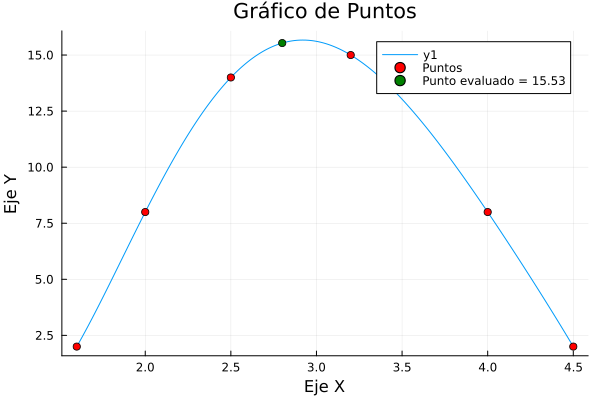

In [88]:
values = [[1.6,2.0],[2.0,8.0],[2.5,14.0],[3.2,15.0],[4.0,8.0],[4.5,2.0]]
value = lagrange_polynomial(values, 2.8) # f(2.8)

plot_lagrange(values,0.01)
scatter!([2.8], [value], label="Punto evaluado = $(Float16(value))", color=:green)

---

**5.1 Teniendo en cuenta la siguiente tabla de datos:**

<center>

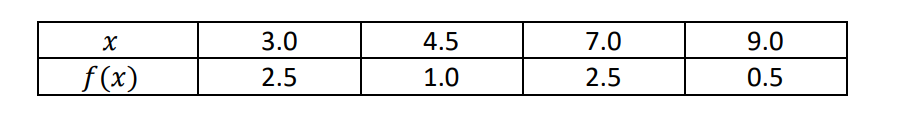

</center>

* Encuentre el spline cúbico que pase por los puntos de la tabla de datos.
* Grafique la tabla de datos y el spline obtenido.
* Utilice los resultados para estimar el valor en 𝑥 = 5.


## Cubic splines

In [89]:
function build_continuity_coefficients(X::Matrix{Float64}, points::Vector{Vector{Float64}})

    """
        Given a matrix full of zeros, and of size (4n, 4n), where n is the number of polynomials to be found
        for the cubic spline, this function fills the upper part of the matrix corresponding to the equations 
        that say that the polynomials must be continuous at the intersections of the intervals.

        Arguments:
        ----------------
            X: Matrix of zeros of size (4n, 4n)
            points: Vector of points [x,y] to be interpolated
        
        Returns:
        ----------------
            X: Matrix of zeros of size (4n, 4n) with the continuity coefficients filled.
    """

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    row = 1
    n_intervals = length(points) - 1

    # Fill the upper part of the matrix
    for i in 1:n_intervals
        
        # Columns to be filled
        cols = (4 * i - 3):(4 * i)
        
        # Points to get the coefficients to fill the columns with
        start_point = points[i]
        end_point = points[i + 1]

        X[row, cols] = [start_point[1]^3, start_point[1]^2, start_point[1], 1]
        X[row+1, cols] = [end_point[1]^3, end_point[1]^2, end_point[1], 1]
        row += 2
    end
    

    return X
end

function build_first_derivative_continuity_coefficients(X::Matrix{Float64}, points::Vector{Vector{Float64}})

    """
        Given a matrix full of zeros, and of size (4n, 4n), where n is the number of polynomials to be found
        for the cubic spline, this function fills the middle part of the matrix corresponding to the equations 
        that say that the first derivative of the polynomials must be continuous at the intersections of the intervals, 
        this is that the first derivative of the polynomial at the end of an interval must be equal to the first derivative
        of the polynomial at the beginning of the next interval.

        Arguments:
        ----------------
            X: Matrix of zeros of size (4n, 4n)
            points: Vector of points [x,y] to be interpolated
        
        Returns:
        ----------------
            X: Matrix of zeros of size (4n, 4n) with the first derivative continuity coefficients filled.
    """

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    n_intervals = length(points) - 1
    row = 2*(n_intervals)+ 1  # 2(n -1) + 1 

    # Fill the first mid part part of the matrix
    for i in 1:n_intervals-1
        
        # Columns to be filled
        col1 = (4 * i - 3):(4 * i)
        col2 = (4 * i + 1):(4 * i + 4)

        # Points to get the coefficients to fill the columns with
        start_point = points[i+1]

        X[row, col1] = [-3*start_point[1]^2, -2*start_point[1], -1, 0]
        X[row, col2] = [ 3*start_point[1]^2,    2*start_point[1],    1, 0]

        row += 1
    end
    
    return X
end

function build_second_derivative_continuity_coefficients(X::Matrix{Float64}, points::Vector{Vector{Float64}})

    """
        Given a matrix full of zeros, and of size (4n, 4n), where n is the number of polynomials to be found
        for the cubic spline, this function fills the second mid part of the matrix corresponding to the equations 
        that say that the second derivative of the polynomials must be continuous at the intersections of the intervals, 
        this is that the second derivative of the polynomial at the end of an interval must be equal to the second derivative
        of the polynomial at the beginning of the next interval.

        Arguments:
        ----------------
            X: Matrix of zeros of size (4n, 4n)
            points: Vector of points [x,y] to be interpolated
        
        Returns:
        ----------------
            X: Matrix of zeros of size (4n, 4n) with the second derivative continuity coefficients filled.
    """

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    n_intervals = length(points) - 1
    row = 3*(n_intervals) # 3(n-1) = 3(n) -4 +1

    # Fill the second mid part part of the matrix
    for i in 1:n_intervals-1
        
        # Columns to be filled
        col1 = (4 * i - 3):(4 * i)
        col2 = (4 * i + 1):(4 * i + 4)

        # Points to get the coefficients to fill the columns with
        start_point = points[i+1]

        X[row, col1] = [-6*start_point[1], -2, 0, 0]
        X[row, col2] = [ 6*start_point[1],  2, 0, 0]

        row += 1
    end
    
    return X

end

function build_second_derivative_natural_coefficients(X::Matrix{Float64}, points::Vector{Vector{Float64}})

    """
        Given a matrix full of zeros, and of size (4n, 4n), where n is the number of polynomials to be found
        for the cubic spline, this function fills the second mid part of the matrix corresponding to the equations 
        that say that the second derivative of the polynomials must be equal to zero at the beginning and end of the 
        interval.

        Arguments:
        ----------------
            X: Matrix of zeros of size (4n, 4n)
            points: Vector of points [x,y] to be interpolated
        
        Returns:
        ----------------
            X: Matrix of zeros of size (4n, 4n) with the second derivative natural coefficients filled.
    """

    # Check that the matrix is square
    size(X, 1) == size(X, 2) || error("The matrix must be square")

    n_intervals = length(points) - 1
    row = 2*(2*(n_intervals+1)-3) + 1  # 2(2(n)-3) + 1

    # Columns to be filled
    col1 = 1:4
    col2 = (n_intervals*4 - 3):(n_intervals*4)

    # Points to get the coefficients to fill the columns with
    start_point = points[1]
    end_point = points[end]

    # Fill the second mid part part of the matrix
    X[row, col1] = [6*start_point[1], 2, 0, 0]
    X[row+1,col2] = [6*end_point[1], 2, 0, 0]

    return X
end

build_second_derivative_natural_coefficients (generic function with 1 method)

In [90]:
function build_cubic_spline_matrix(points::Vector{Vector{Float64}})

    """
        Given a vector of points [x,y] to be interpolated, this function builds the matrix of coefficients
        for the cubic spline method.

        Arguments:
        ----------------
            points: Vector of points [x,y] to be interpolated
        
        Returns:
        ----------------
            X: Matrix of coefficients for the cubic spline method.
    """

    n_intervals = length(points) - 1

    #matrix of zeros of size (4n, 4n)
    X = zeros(4 * n_intervals, 4 * n_intervals)

    #fill the upper part of the matrix and print the complete matrix
    X = build_continuity_coefficients(X, points)
    X = build_first_derivative_continuity_coefficients(X, points)
    X = build_second_derivative_continuity_coefficients(X, points)
    X = build_second_derivative_natural_coefficients(X, points)

    return X
end

function build_output_vector(points::Vector{Vector{Float64}})

    """
        Given a vector of points [x,y] to be interpolated, this function builds the output vector
        for the cubic spline method.

        Arguments:
        ----------------
            points: Vector of points [x,y] to be interpolated.
        
        Returns:
        ----------------
            Y: Vector of coefficients for the cubic spline method.
    """

    n_intervals = length(points) - 1

    #vector of zeros of size (4n, 1)
    Y = zeros(4 * n_intervals, 1)


    #fill the upper part of the matrix and print the complete matrix
    Y[1] = points[1][2]
    Y[2*(n_intervals-1)+2] = points[end][2]

    row = 2
    for i in 2:n_intervals
        Y[row] = points[i][2]
        Y[row+1] = points[i][2]
        row += 2
    end

    return Y

end

build_output_vector (generic function with 1 method)

In [91]:
function build_and_solve_coefficients(points::Vector{Vector{Float64}})::Matrix{Float64}

    """
        Given a vector of points [x,y] to be interpolated, this function builds the matrix of coefficients
        and the output vector for the cubic spline method, and then solves the system of equations.

        Arguments:
        ----------------
            points: Vector of points [x,y] to be interpolated.
        
        Returns:
        ----------------
            coefficients: Vector of coefficients for the cubic spline method.
    """


    X = build_cubic_spline_matrix(points)
    Y = build_output_vector(points)
    return X\Y
end

function build_cubic_splines(points::Vector{Vector{Float64}}, x::Num)::Vector{Tuple{Function, Float64, Float64}}

    """
        Given a vector of points [x,y] to be interpolated, this function builds the cubic splines
        for the cubic spline method.

        Arguments:
        ----------------
            points: Vector of points [x,y] to be interpolated.
            x: Symbolics variable to build the polynomials
        
        Returns:
        ----------------
            polynomials: Vector of polynomials for the cubic spline method.
    """

    #sort points by x value 
    points = sort(points, by = x -> x[1])
    
    #build and solve the coefficients
    coefficients = build_and_solve_coefficients(points)
    n_intervals = length(points) - 1
    polynomials = []

    #build the polynomials
    for i in 1:n_intervals
        start_point = points[i]
        end_point = points[i+1]
        polynomial = coefficients[4*i-3]*x^3 + coefficients[4*i-2]*x^2 + coefficients[4*i-1]*x + coefficients[4*i]
        push!(polynomials, (Symbolics.build_function(polynomial, x, expression = false) , start_point[1],end_point[1]))
    end
    return polynomials
end


function interpolate(polynomals::Vector{Tuple{Function, Float64, Float64}}, x::Float64)::Float64
    """
        Given a vector of polynomials, this function interpolates the value of x using the polynomials.

        Arguments:
        ----------------
            polynomals: Vector of polynomials for the cubic spline method.
            x: value to interpolate
        
        Returns:
        ----------------
            y: interpolated value.
    """
    for polynomial in polynomals
        if x >= polynomial[2] && x <= polynomial[3]
            return polynomial[1](x)
        end
    end
    return nothing
end

interpolate (generic function with 1 method)

In [92]:
function plot_cubic_spline(points::Vector{Vector{Float64}}, polynomals::Vector{Tuple{Function, Float64, Float64}}, step::Float64)
    """
        Given a vector of points [x,y] to be interpolated, this function builds the cubic splines
        for the cubic spline method.

        Arguments:
        ----------------
            points: Vector of points [x,y] to be interpolated.
            polynomals: Vector of polynomials for the cubic spline method.
            step: step to plot the polynomials
        
        Returns:
        ----------------
            polynomials: Vector of polynomials for the cubic spline method.
    """
    
    start = points[1][1]
    stop = points[end][1]

    pts = [[x, interpolate(polynomals, x)] for x = start:step:stop]

    x = [p[1] for p in pts]
    y = [p[2] for p in pts]

    # Graficar puntos utilizando scatter() 
    plot(x, y, legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")
    # Agregar puntos de construccion
    scatter!([i[1] for i in points],[i[2] for i in points], label="Puntos", color=:red)   
end

plot_cubic_spline (generic function with 1 method)

---

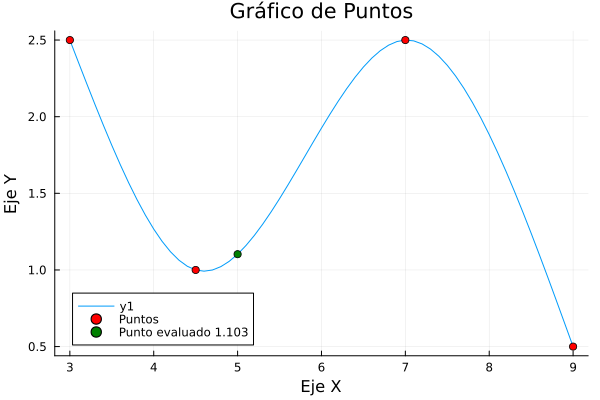

In [93]:
@variables x
points = [[3.0, 2.5], [4.5, 1.0], [7.0, 2.5], [9.0, 0.5]]
polynomials = build_cubic_splines(points, x)

plot_cubic_spline(points, polynomials, 0.1)
# evaluate the polynomial in x = 5 
value = interpolate(polynomials, 5.0)
#plot the point and add to the legend with only 3 decimals
scatter!([5], [value], label="Punto evaluado $(Float16(value))", color=:green)

---

**5.2 Teniendo en cuenta la siguiente tabla de datos:**

<center>

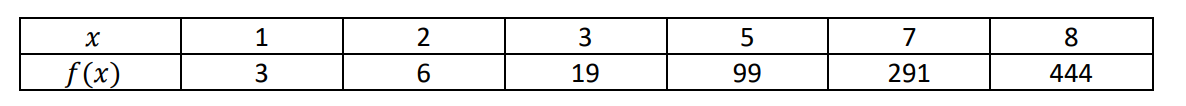

</center>

* Encuentre el spline cúbico que pase por los puntos de la tabla de datos.
* Grafique la tabla de datos y el spline obtenido.
* Utilice los resultados para estimar el valor en 𝑥 = 4 y 𝑥 = 2.25.



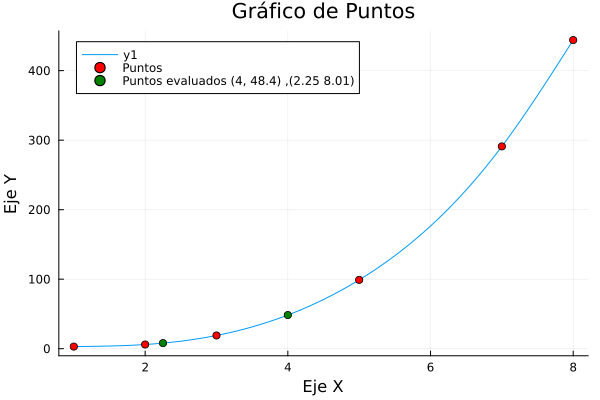

In [94]:
@variables x
points = [[1.0, 3.0], [2.0, 6.0], [3.0, 19.0], [5.0, 99.0], [7.0, 291.0], [8.0, 444.0]]
polynomials = build_cubic_splines(points, x)

plot_cubic_spline(points, polynomials,0.1)
# evaluate the polynomial in x = 4 and x = 2.25
value1 = interpolate(polynomials, 4.0)
value2 = interpolate(polynomials, 2.25)
#plot the point and add to the legend with only 3 decimals
scatter!([4,2.25], [value1,value2], label="Puntos evaluados (4, $(Float16(value1))) ,(2.25 $(Float16(value2)))", color=:green)

---

**6. Desarrolle un código que permita calcular el valor de intermedio en una tabla de  datos a partir de Polinomios de Lagrange. El código debe recibir dos arreglos unidimensionales  que representan 𝑥 y 𝑓(𝑥) y un valor que se desee estimar a partir de la información contenida en dichos arreglos. El código debe encontrar el intervalo en donde se localiza el valor que se desea estimar y luego aproximarlo mediante polinomios cúbicos de Lagrange. Para los intervalos primero y último emplee polinomios cuadráticos y para valores fuera del rango de datos indique la presencia de un error en la información suministrada. Una vez realizado el código puede probarlo con 𝑓(𝑥) = ln 𝑥 siendo 𝑥 = 1, 2, 3, … , 10.**


In [95]:
function value_intermediate(x_values::Vector{Float64}, y_values::Vector{Float64})

    """
        Given a set of points, this function divides the points in three groups, the first group contains the first three points,
        the second group contains the points from the fourth to the last three points, and the third group contains the last three points.

        Arguments:
        ----------------
            x_values: Vector of x values of the points to be interpolated.
            y_values: Vector of y values of the points to be interpolated.
        
        Returns:
        ----------------
            left: Vector of points [x,y] to be interpolated.
            mid: Vector of points [x,y] to be interpolated.
            right: Vector of points [x,y] to be interpolated.
    """

    # condition (n -4) % 3 == 1  or len(x) != len(y) or len(x) < 5
    if (length(x_values) - 4) % 3 != 1 || length(x_values) != length(y_values) || length(x_values) < 5
        println("The number of points is not correct")
        return nothing
    end

    left = [[x_values[i], y_values[i]] for i in 1:3]
    right = [[x_values[i], y_values[i]] for i in length(x_values)-2:length(x_values)]

    mid = [[ [x_values[j], y_values[j]] for j in i:i+3 ] for i in 3:3:length(x_values)-3]

    return left, mid, right
end

function find_polynomium(left::Vector{Vector{Float64}}, mid::Vector{Vector{Vector{Float64}}}, right::Vector{Vector{Float64}}, target::Float64)


    """
        Given a set of points, this function finds the polynomium that interpolates the points where the target is located.

        Arguments:
        ----------------
            left: Vector of points [x,y] to be interpolated.
            mid: Vector of points [x,y] to be interpolated.
            right: Vector of points [x,y] to be interpolated.
            target: value to interpolate
        
        Returns:
        ----------------
            polynomium: Vector of polynomials for the cubic spline method.
    """

    n = length(x_values)
    if target in 1:0.1:3
        # return lagrange_polynomial(left, target)
        return left
    elseif target in length(x_values)-2:0.1:length(x_values)
        # return lagrange_polynomial(right, target)
        return right
    else
        for i in 1:length(mid)
            if target in 3*i:0.1:3*i+3
                # return lagrange_polynomial(mid[i], target)
                return mid[i]
            end
        end
    end
end


function plot_polynomiun(x_values::Vector{Float64}, y_values::Vector{Float64}, step::Float64)

    """
        Given a set of points, this function plots the polynomium that interpolates the points.

        Arguments:
        ----------------
            x_values: Vector of x values of the points to be interpolated.
            y_values: Vector of y values of the points to be interpolated.
            step: step to plot the polynomials
        
        Returns:
        ----------------
            polynomials: Vector of polynomials for the cubic spline method.
    """
    
    start = x_values[1]
    stop = x_values[end]

    left, mid, right = value_intermediate(x_values, y_values)
    pts = [[x, lagrange_polynomial( find_polynomium(left,mid, right, x) , x)] for x = start:step:stop]

    x = [p[1] for p in pts]
    y = [p[2] for p in pts]

    # Graficar puntos utilizando scatter() 
    plot(x, y, legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")
    # Agregar puntos de construccion
    scatter!([i for i in x_values],[i for i in y_values], label="Puntos", color=:red)   
end

plot_polynomiun (generic function with 1 method)

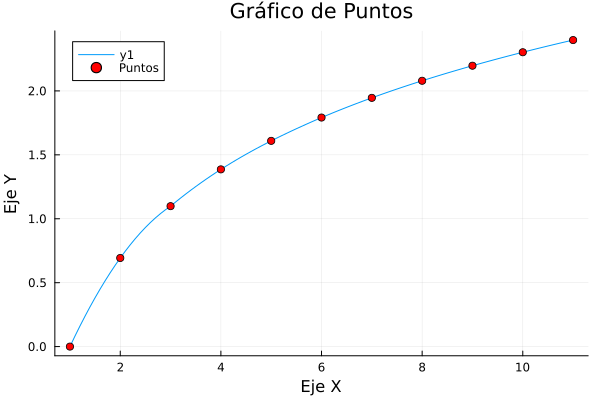

In [96]:
x_values = [i for i in 1:1.0:11]
y_values = [log(i) for i in x_values]

plot_polynomiun(x_values, y_values, 0.1)

---

**7. Para la siguiente ecuación:**


$$
𝑓(𝑥) = \frac{1}{1+25x^2}
$$

* Grafique la función en el intervalo de 𝑥 = −1 a 1
* Obtenga y grafique el polinomio de Lagrange usando los valores de la función  equiespaciados 𝑥 = [−1 −0.5 0 0.5 1]
* Repita el numeral 𝑏 empleando spline cúbicos. 
* Explique sus resultados.

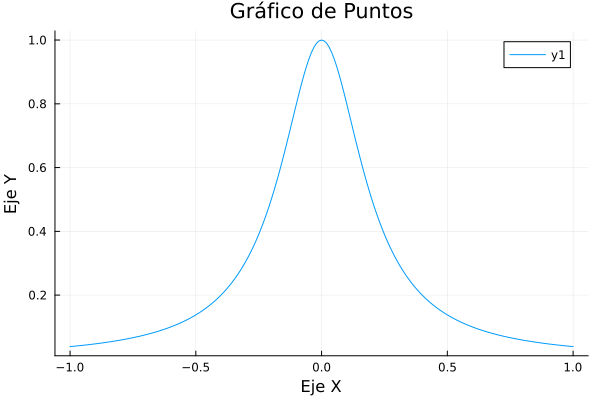

In [97]:
function f(x)
    return 1/(1 + 25*x^2)
end

# plot the function vectoracing in the range (-1,1)
x = -1:0.01:1
plot( x , f.(x), legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")


* conjunto de muestreo = [-1, -0.5, 0, 0.5, 1]

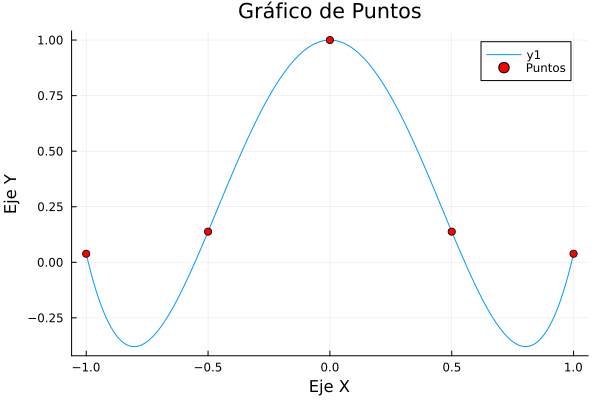

In [98]:
samples = [ [i, f(i)] for i = -1:0.5:1 ]
plot_lagrange(samples, 0.01)

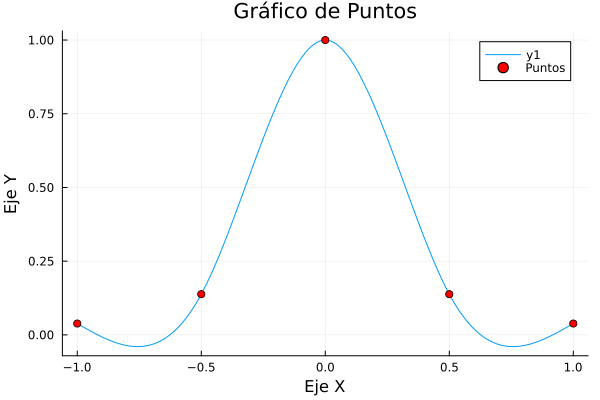

In [99]:
@variables x
polynomials = build_cubic_splines(samples, x)
plot_cubic_spline(samples, polynomials, 0.01)

* conjunto de muestreo = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

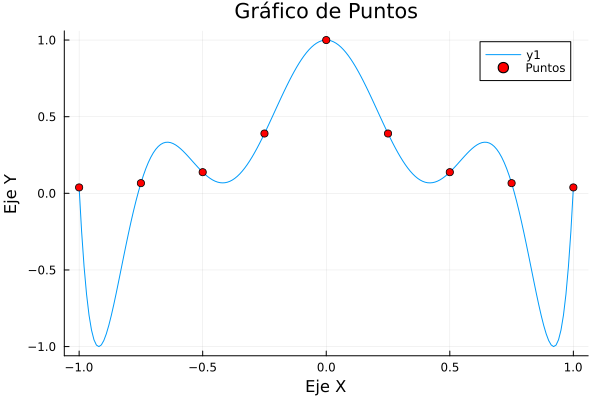

In [100]:
samples = [ [i, f(i)] for i = -1:0.25:1]
plot_lagrange(samples, 0.01)

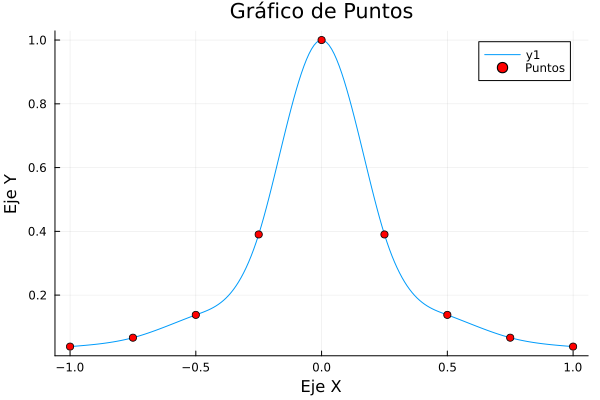

In [101]:
@variables x
polynomials = build_cubic_splines(samples, x)
plot_cubic_spline(samples, polynomials, 0.01)

En este caso tenemos una función que se asemeja a una campana gaussiana, teniendo en cuenta las graficas obtenidas con un tamaño de paso de 0.5, se podria decir que ambas hacen un buen trabajo, sin embargo lagrange aproxima un poco peor cerca de los extremos.

Al disminuir el tamaño del paso a 0.25, los splines cubicos aproximan mucho mejor la función, por otro lado Lagrange hace una peor aproximación a el anterior caso, esto se puede deber a un sobre ajuste en los datos, en otras palabras lagrange es un metodo muy sensible al ruido y que se asemeja mas a funciones senoidales y cosenoidales, y splines cubicos funciona en mas casos dado que aproxima mejor la mayoria de las funciones.